In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import umap
import itertools
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.cm as cm
import matplotlib.colors as colors

sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings, calc_cascaded_loadings
from loaders import load_sabes
from decoders import lr_decoder
from segmentation import reach_segment_sabes, measure_straight_dev
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')
#from psth_ilmerge import get_top_neurons, get_top_neurons_alt

In [1]:
# Can we devise a setting in which large subspace angles are driven only be the divergence in importance scores of a few neurons?

In [6]:
def get_top_neurons(dimreduc_df, fraction_cutoff=0.9, method1='FCCA', method2='PCA', n=10, 
                    pairwise_exclude=True, data_path=None, T=None, bin_width=None):

    if data_path is None:
        data_path = globals()['data_path']
    if T is None:
        T = globals()['T']
    if bin_width is None:
        bin_width = globals()['bin_width']

    # Load dimreduc_df and calculate loadings
    data_files = np.unique(dimreduc_df['data_file'].values)

    # get the leverage scores and coefficient matrices for a single fold
    loadings_l = []
    coef_l = []
    for i, data_file in tqdm(enumerate(data_files)):
        for dimreduc_method in ['LQGCA']:
            df_ = apply_df_filters(dimreduc_df, data_file=data_file, fold_idx=0, dim=6, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
                assert(df_.shape[0] == 1)
                V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:6]        

            loadings_l.append(calc_loadings(V))
            coef_l.append(V)

    return loadings_l, coef_l

In [7]:
# Do this directly on the data - 
#dframe = '/home/akumar/nse/neural_control/data/indy_decoding_marginal.dat'
dframe_indy = '/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat'
dframe_loco = '/mnt/Secondary/data/postprocessed/loco_decoding_df.dat'

data_path = '/mnt/Secondary/data/sabes'
T = 30
n = 10
bin_width = 50

print('Using dframes %s, %s' % (dframe_indy, dframe_loco))

with open(dframe_indy, 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open(dframe_loco, 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        
dimreduc_df = pd.concat([indy_df, loco_df])

Using dframes /mnt/Secondary/data/postprocessed/indy_decoding_df2.dat, /mnt/Secondary/data/postprocessed/loco_decoding_df.dat


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
35it [00:00, 245.02it/s]


In [8]:
loadings_l, coef_l = get_top_neurons(dimreduc_df, method1='FCCA', method2='PCA', n=10, pairwise_exclude=False, data_path=data_path, T=T, bin_width=bin_width)

35it [00:00, 284.65it/s]


In [12]:
# Multiply row entries of the smallest 10 neurons by loadings by a multiplicative factor delta, and then re-orthogonalize 
def modify_coef(coef, loadings, delta, n=10):
    coef = coef.copy()

    # Get the smallest n neurons
    idx = np.argsort(loadings)
    idx = idx[0:n]

    # Modify the smallest n neurons
    coef[idx, :] = coef[idx, :] * delta

    # Re-orthogonalize
    coef = scipy.linalg.orth(coef)
    return coef, calc_loadings(coef)

In [22]:
ssa = np.zeros((len(coef_l), 6))
lnew_l = []
delta = 100
n = 10
for i in range(len(coef_l)):
    cnew, lnew = modify_coef(coef_l[i], loadings_l[i], delta=delta, n=n)
    ssa[i] = scipy.linalg.subspace_angles(coef_l[i], cnew)
    lnew_l.append(lnew)

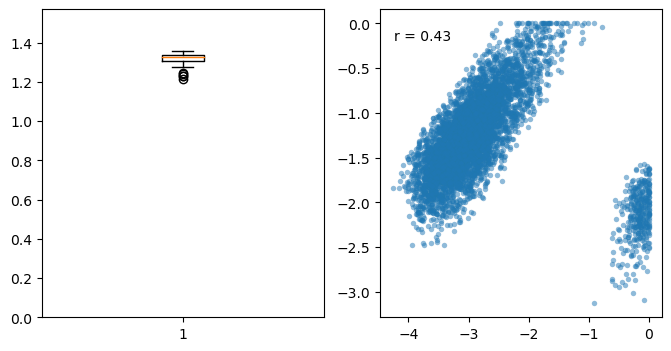

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].boxplot(np.mean(ssa, axis=1))
ax[0].set_ylim([0, np.pi/2])
x1 = []
[x1.extend(l) for l in lnew_l]
x2 = []
[x2.extend(l) for l in loadings_l]
ax[1].scatter(np.log10(x1), np.log10(x2), edgecolors=(0.6, 0.6, 0.6, 0.6), linewidth=0.01, s=15, alpha=0.5)
ax[1].annotate('r = %.2f' % scipy.stats.spearmanr(np.log10(x1), np.log10(x2))[0], xy=(0.05, 0.9), xycoords='axes fraction')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/is_counterfactual.png', dpi=300)
#print(scipy.stats.spearmanr(np.log10(x1), np.log10(x2)))